# Install Requirements

In [2]:
print(tensorflow.__version__)

NameError: name 'tensorflow' is not defined

In [3]:
!pip3 install tensorflow==1.4

     |████████████████████████████████| 41.2 MB 17.9 MB/s eta 0:00:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-serving-api 1.15.0 requires tensorflow~=1.15.0, but you have tensorflow 1.4.0 which is incompatible.


In [54]:
!pip3 install -r requirements.txt
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling bu

In [36]:
!pip3 install mrcnn
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 51 kB 59 kB/s s eta 0:00:01
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54931 sha256=895bb0ebbe581770a08ef58d5399bec3f2280b43f68468efc4586d861e8fcadb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/43/fb/9e/43c34f0f3363eeb1db6b8b71727559bc9ad70c91239bc4d188
Successfully built mrcnn


In [5]:
import lxml.etree

import os
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import load_img
import skimage
from mrcnn import visualize
import tensorflow as tf
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

In [7]:
print(tf.__version__)

1.15.5


# Create class & functions for training dataset to:
- load images and annotations into train dataset
- parse XML annotations to get ground truth bounding boxes for items
- append annotated box/mask to image

In [17]:
class ReceiptDataset(Dataset):
    
    def load_dataset(self, dataset_dir, is_train = True):
        self.add_class("dataset", 1, "Airpods")
        images_dir = dataset_dir + '/cv_images_test/'
        annotations_dir = dataset_dir + '/cv_annots_test/'
        
        #find all the images in this dir
        for filename in os.listdir(images_dir):
            
            #extract image id
            image_id = filename[:-4]
            
            #skip all images after 200 if we're building train set
           # if is_train and image_id in range(400):
              #  continue
            
            #skip all images before 200 if we're building test/val set
          #  if not is_train and int(image_id) < 400:
          #      continue
                
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            #add to dataset
            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)
    def extract_boxes(self, filename):
        tree = lxml.etree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall(".//object"):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin,ymin,xmax,ymax, name]
            if name== 'airpods':
                boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height        
    def load_mask(self, image_id):
        #image_id in this case is integer index for image in dataset, assigned based on order image was added via call to add_image when loading dataset
        #must return array of 1 or more masks for photo associated with image_id, and classes for each mask
        #don't have masks in this dataset, but do have bounding boxes
        # can load bounding boxes for given photo and return them as masks
        # library will then infer bounding boxes from our masks which will be same size
        
        #first load annotation file for image_id
        #first retrieve image info dict for image_id
        info = self.image_info[image_id]
        
        #from that image info dictionary, retrieve annotations path 
        #which was stored under annotation in the add_image step above
        #define box file location
        path = info['annotation']
        
        #then use that path to extract boxes and get list of bounding boxes and dims of image 
        #load XML
        boxes, w,h = self.extract_boxes(path)
        
        #define a mask for each bounding box and an associated class
        #mask = 2d array with same dims as phot0
        #with all zero values where the object isn't and all 1 values where the object is in the photo
        #create numpy array with all zero values for known size of image and 1 channel for each bounding box
        masks = zeros([h,w,len(boxes)], dtype = 'uint8')
        
        #each bounding box defined as min and max, x and y coordinates of the box
        # can be used directly to define row and column ranges in the array that can be marked as 1
        class_ids = list()
        
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i]=1
            class_ids.append(self.class_names.index('Airpods'))
        
        #all objects the same class in this dataset
        #retrieve class index via class_names dictionary
        #add it to a list to be returned alongise the masks
        return masks, asarray(class_ids, dtype = 'int32')
    def image_reference(self, image_id):
        #return path or URL for given image_id
        #just the path property on the image info dict
        info = self.image_info[image_id]
        return info['path']

In [9]:
train_set = ReceiptDataset()

In [10]:
train_set.load_dataset('cv_images_test', is_train =True)

In [11]:
train_set.prepare()

In [12]:
print('Train: %d' % len(train_set.image_ids))

Train: 28


look at example

In [13]:
image_id = 1
image = train_set.load_image(image_id)
print(image.shape)

(4000, 4000, 3)


In [14]:
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(4000, 4000, 1)


In [15]:
mask

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [16]:
class ReceiptDataset(Dataset):
    
    def load_dataset(self, dataset_dir, is_train = True):
        self.add_class("dataset", 1, "Receipt")
        self.add_class("dataset", 2, "Logo")
        self.add_class("dataset", 3, "Total")
        self.add_class("dataset", 4, "Items")
        self.add_class("dataset", 5, "Purchase_Date")
        images_dir = dataset_dir + '/target_images/'
        annotations_dir = dataset_dir + '/target_annotations/'
        
        #find all the images in this dir
        for filename in os.listdir(images_dir):
            
            #extract image id
            image_id = filename[:-5]
            
            #skip all images after 200 if we're building train set
           # if is_train and image_id in range(400):
              #  continue
            
            #skip all images before 200 if we're building test/val set
          #  if not is_train and int(image_id) < 400:
          #      continue
                
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            #add to dataset
            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path, class_ids = [0,1,2])
    def extract_boxes(self, filename):
        tree = lxml.etree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall(".//object"):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin,ymin,xmax,ymax, name]
            if name== 'Receipt' or name=='Logo' or name=='Total' or name=='Items' or name=='Purchase_Date':
                boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height        
    def load_mask(self, image_id):
        #image_id in this case is integer index for image in dataset, assigned based on order image was added via call to add_image when loading dataset
        #must return array of 1 or more masks for photo associated with image_id, and classes for each mask
        #don't have masks in this dataset, but do have bounding boxes
        # can load bounding boxes for given photo and return them as masks
        # library will then infer bounding boxes from our masks which will be same size
        
        #first load annotation file for image_id
        #first retrieve image info dict for image_id
        info = self.image_info[image_id]
        
        #from that image info dictionary, retrieve annotations path 
        #which was stored under annotation in the add_image step above
        #define box file location
        path = info['annotation']
        
        #then use that path to extract boxes and get list of bounding boxes and dims of image 
        #load XML
        boxes, w,h = self.extract_boxes(path)
        
        #define a mask for each bounding box and an associated class
        #mask = 2d array with same dims as phot0
        #with all zero values where the object isn't and all 1 values where the object is in the photo
        #create numpy array with all zero values for known size of image and 1 channel for each bounding box
        masks = zeros([h,w,len(boxes)], dtype = 'uint8')
        
        #each bounding box defined as min and max, x and y coordinates of the box
        # can be used directly to define row and column ranges in the array that can be marked as 1
        class_ids = list()
        
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Receipt'):
                masks[row_s:row_e, col_s:col_e, i]=1
                class_ids.append(self.class_names.index('Receipt'))
            
            elif (box[4] == 'Logo'):
                masks[row_s:row_e, col_s:col_e, i]=2
                class_ids.append(self.class_names.index('Logo'))
            elif (box[4] == 'Total'):
                masks[row_s:row_e, col_s:col_e, i]=3
                class_ids.append(self.class_names.index('Total'))
            elif (box[4] == 'Items'):
                masks[row_s:row_e, col_s:col_e, i]=4
                class_ids.append(self.class_names.index('Items'))
            else:
                masks[row_s:row_e, col_s:col_e, i]=5
                class_ids.append(self.class_names.index('Purchase_Date'))
        
        #all objects the same class in this dataset
        #retrieve class index via class_names dictionary
        #add it to a list to be returned alongise the masks
        return masks, asarray(class_ids, dtype = 'int32')
    def image_reference(self, image_id):
        #return path or URL for given image_id
        #just the path property on the image info dict
        info = self.image_info[image_id]
        return info['path']

# Load & prepare training dataset

In [23]:
train_set = ReceiptDataset()

In [24]:
train_set.load_dataset('cv_images_test', is_train =True)

In [25]:
train_set.prepare()

In [26]:
print('Train: %d' % len(train_set.image_ids))

Train: 30


look at example

In [18]:
image_id = 4
image = train_set.load_image(image_id)
print(image.shape)

(4000, 6000, 3)


In [19]:
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(4000, 6000, 1)


In [20]:
mask

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

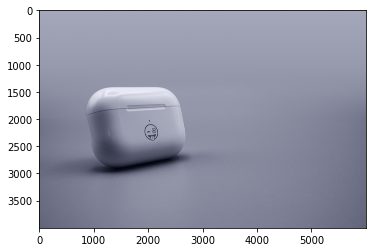

In [21]:
plt.imshow(image)

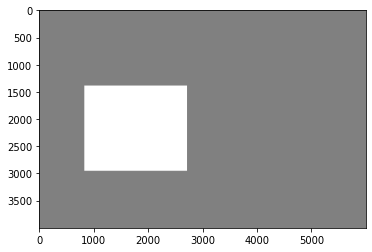

In [22]:
plt.imshow(mask[:,:,0],cmap='gray',alpha =0.5)
plt.show()

In [23]:
bbox = extract_bboxes(mask)

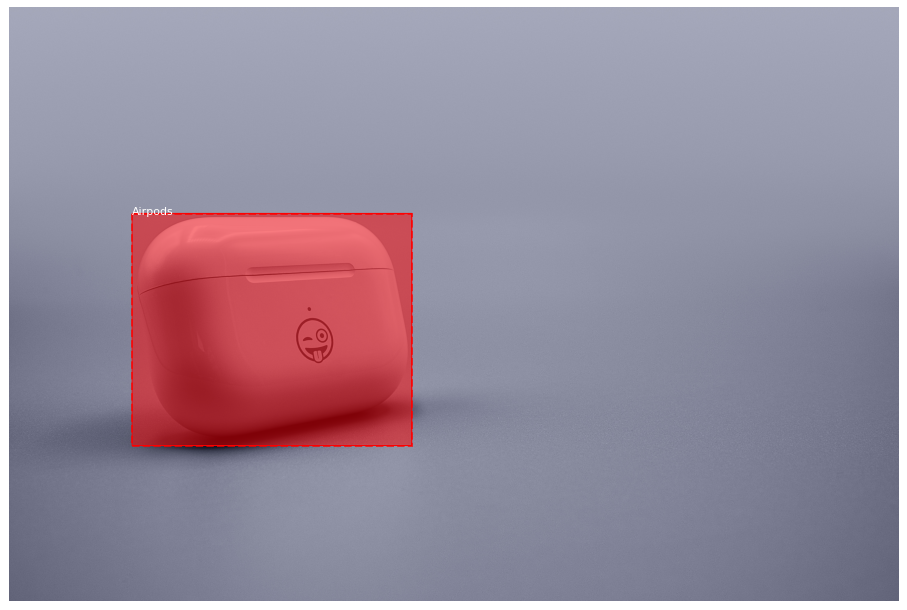

In [24]:
display_instances(image,bbox,mask,class_ids,train_set.class_names)

# Create class & functions for test dataset to:
- load images and annotations into train dataset
- parse XML annotations to get ground truth bounding boxes for items
- append annotated box/mask to image

In [25]:
class ReceiptDataset(Dataset):
    
    def load_dataset(self, dataset_dir, is_train = True):
        self.add_class("dataset", 1, "Airpods")
        images_dir = dataset_dir + '/cv_images_train/'
        annotations_dir = dataset_dir + '/cv_annots_train/'
        
        #find all the images in this dir
        for filename in os.listdir(images_dir):
            
            #extract image id
            image_id = filename[:-4]
            
            #skip all images after 200 if we're building train set
           # if is_train and image_id in range(400):
              #  continue
            
            #skip all images before 200 if we're building test/val set
          #  if not is_train and int(image_id) < 400:
          #      continue
                
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            #add to dataset
            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)
    def extract_boxes(self, filename):
        tree = lxml.etree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall(".//object"):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin,ymin,xmax,ymax, name]
            if name== 'airpods':
                boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height        
    def load_mask(self, image_id):
        #image_id in this case is integer index for image in dataset, assigned based on order image was added via call to add_image when loading dataset
        #must return array of 1 or more masks for photo associated with image_id, and classes for each mask
        #don't have masks in this dataset, but do have bounding boxes
        # can load bounding boxes for given photo and return them as masks
        # library will then infer bounding boxes from our masks which will be same size
        
        #first load annotation file for image_id
        #first retrieve image info dict for image_id
        info = self.image_info[image_id]
        
        #from that image info dictionary, retrieve annotations path 
        #which was stored under annotation in the add_image step above
        #define box file location
        path = info['annotation']
        
        #then use that path to extract boxes and get list of bounding boxes and dims of image 
        #load XML
        boxes, w,h = self.extract_boxes(path)
        
        #define a mask for each bounding box and an associated class
        #mask = 2d array with same dims as phot0
        #with all zero values where the object isn't and all 1 values where the object is in the photo
        #create numpy array with all zero values for known size of image and 1 channel for each bounding box
        masks = zeros([h,w,len(boxes)], dtype = 'uint8')
        
        #each bounding box defined as min and max, x and y coordinates of the box
        # can be used directly to define row and column ranges in the array that can be marked as 1
        class_ids = list()
        
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i]=1
            class_ids.append(self.class_names.index('Airpods'))
        
        #all objects the same class in this dataset
        #retrieve class index via class_names dictionary
        #add it to a list to be returned alongise the masks
        return masks, asarray(class_ids, dtype = 'int32')
    def image_reference(self, image_id):
        #return path or URL for given image_id
        #just the path property on the image info dict
        info = self.image_info[image_id]
        return info['path']

In [26]:
test_set = ReceiptDataset()

In [27]:
test_set.load_dataset('cv_images_test', is_train =False)

In [28]:
test_set.prepare()

In [29]:
print('Train: %d' % len(test_set.image_ids))

Train: 3


In [290]:
class ReceiptDataset(Dataset):
    
    def load_dataset(self, dataset_dir, is_train = True):
        self.add_class("dataset", 1, "Receipt")
        self.add_class("dataset", 2, "Logo")
        self.add_class("dataset", 3, "Total")
        self.add_class("dataset", 4, "Items")
        self.add_class("dataset", 5, "Purchase_Date")
        images_dir = dataset_dir + '/target_images_test/'
        annotations_dir = dataset_dir + '/target_annotations_test/'
        
        #find all the images in this dir
        for filename in os.listdir(images_dir):
            
            #extract image id
            image_id = filename[:-5]
            
            #skip all images after 200 if we're building train set
           # if is_train and image_id in range(400):
              #  continue
            
            #skip all images before 200 if we're building test/val set
          #  if not is_train and int(image_id) < 400:
          #      continue
                
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            #add to dataset
            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path, class_ids = [0,1,2])
    def extract_boxes(self, filename):
        tree = lxml.etree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall(".//object"):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin,ymin,xmax,ymax, name]
            if name== 'Receipt' or name=='Logo' or name=='Total' or name=='Items' or name=='Purchase_Date':
                boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height        
    def load_mask(self, image_id):
        #image_id in this case is integer index for image in dataset, assigned based on order image was added via call to add_image when loading dataset
        #must return array of 1 or more masks for photo associated with image_id, and classes for each mask
        #don't have masks in this dataset, but do have bounding boxes
        # can load bounding boxes for given photo and return them as masks
        # library will then infer bounding boxes from our masks which will be same size
        
        #first load annotation file for image_id
        #first retrieve image info dict for image_id
        info = self.image_info[image_id]
        
        #from that image info dictionary, retrieve annotations path 
        #which was stored under annotation in the add_image step above
        #define box file location
        path = info['annotation']
        
        #then use that path to extract boxes and get list of bounding boxes and dims of image 
        #load XML
        boxes, w,h = self.extract_boxes(path)
        
        #define a mask for each bounding box and an associated class
        #mask = 2d array with same dims as phot0
        #with all zero values where the object isn't and all 1 values where the object is in the photo
        #create numpy array with all zero values for known size of image and 1 channel for each bounding box
        masks = zeros([h,w,len(boxes)], dtype = 'uint8')
        
        #each bounding box defined as min and max, x and y coordinates of the box
        # can be used directly to define row and column ranges in the array that can be marked as 1
        class_ids = list()
        
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Receipt'):
                masks[row_s:row_e, col_s:col_e, i]=1
                class_ids.append(self.class_names.index('Receipt'))
            
            elif (box[4] == 'Logo'):
                masks[row_s:row_e, col_s:col_e, i]=2
                class_ids.append(self.class_names.index('Logo'))
            elif (box[4] == 'Total'):
                masks[row_s:row_e, col_s:col_e, i]=3
                class_ids.append(self.class_names.index('Total'))
            elif (box[4] == 'Items'):
                masks[row_s:row_e, col_s:col_e, i]=4
                class_ids.append(self.class_names.index('Items'))
            else:
                masks[row_s:row_e, col_s:col_e, i]=5
                class_ids.append(self.class_names.index('Purchase_Date'))
        
        #all objects the same class in this dataset
        #retrieve class index via class_names dictionary
        #add it to a list to be returned alongise the masks
        return masks, asarray(class_ids, dtype = 'int32')
    def image_reference(self, image_id):
        #return path or URL for given image_id
        #just the path property on the image info dict
        info = self.image_info[image_id]
        return info['path']

# Load & prepare test dataset

In [291]:
test_set = ReceiptDataset()

In [292]:
test_set.load_dataset('target_receipt_images', is_train =False)

In [293]:
test_set.prepare()

In [294]:
print('Train: %d' % len(test_set.image_ids))

Train: 52


# Define configuration for model

In [30]:
# define a configuration for the model
class ReceiptConfig(Config):
    
  # Give the configuration a recognizable name
    NAME = "airpods_cfg"
  # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
  # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    # TODO: prepared elsewhere, need to add in 
   # MEAN_PIXEL = [168, 154, 144] 

In [31]:
# prepare config
config = ReceiptConfig()

In [32]:
#mean pixel value displayed here 
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Load in model

In [33]:
model = MaskRCNN(mode='training', model_dir='./', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [34]:
weights_path = 'mask_rcnn_coco.h5'

In [35]:
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits","mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# Train model with transfer learning:
- try more approaches here
- currently just training top layer
- layers = 4+ will train more
- layers = all will train whole thing

In [37]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1,layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./airpods_cfg20210401T2046/mask_rcnn_airpods_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/home/ec2-user/anaconda3/envs/tensorflow_p36/cpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow_p36/cpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow_p36/cpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-

Epoch 1/1
131/131 [==============================] - 1095s 8s/step - loss: 0.3422 - rpn_class_loss: 3.2304e-04 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1802 - val_loss: 0.7139 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.0430 - val_mrcnn_class_loss: 0.0027 - val_mrcnn_bbox_loss: 0.1706 - val_mrcnn_mask_loss: 0.4933



# Define prediction configuration

In [84]:
class PredictionConfig(Config):
  # define the name of the configuration
    NAME = "pred_cfg"
  # number of classes (background + receipt)
    NUM_CLASSES = 1 + 1
  # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = .95

In [85]:
#create config
cfg = PredictionConfig()

In [86]:
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [295]:
class PredictionConfig(Config):
  # define the name of the configuration
    NAME = "pred_cfg"
  # number of classes (background + receipt)
    NUM_CLASSES = 1 + 5
  # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [296]:
#create config
cfg = PredictionConfig()

# Define model for inferencing

In [87]:
#define the model
model = MaskRCNN(mode='inference', model_dir='./', config = cfg)

# Load trained weights from above

In [88]:
model_path = 'airpods_cfg20210401T2046/mask_rcnn_airpods_cfg_0001.h5'

In [89]:
model.load_weights(model_path, by_name=True)

# load example instance not in training dataset

In [68]:
image_path = 'cv_images_test/cv_images_train/amr-taha-arfL72zV4tA-unsplash.jpg'

In [69]:
image =skimage.io.imread(image_path)

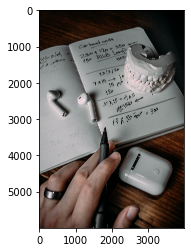

In [70]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [71]:
scaled_image = mold_image(image,cfg)

In [72]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [73]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [74]:
#extract results
r = yhat[0]

# Visualize results

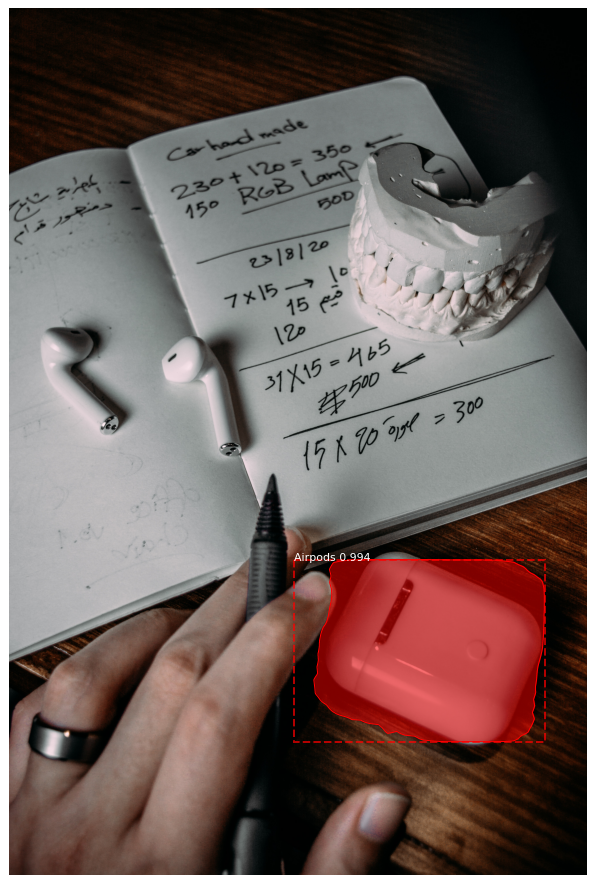

In [75]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

# load example instance not in training dataset

In [90]:
image_path = 'cv_images_test/cv_images_train/aaron-boris-y4sFIkLwVwU-unsplash.jpg'

In [91]:
image =skimage.io.imread(image_path)

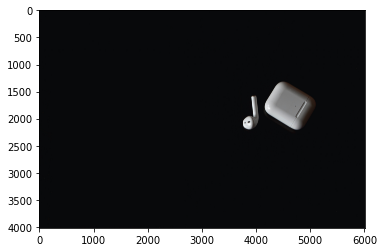

In [92]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [93]:
scaled_image = mold_image(image,cfg)

In [94]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [95]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [96]:
#extract results
r = yhat[0]

# Visualize results

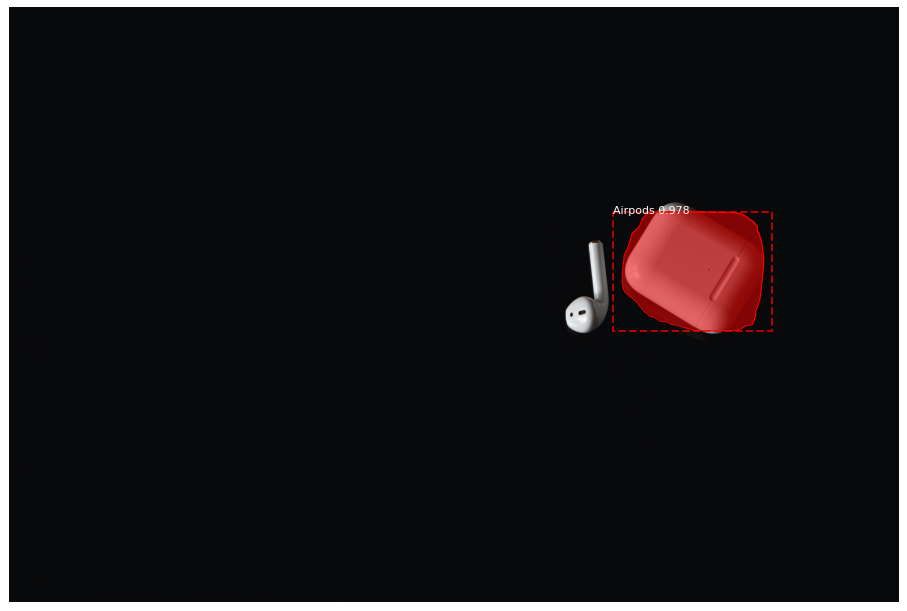

In [97]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

In [101]:
image_path = 'cv_images_test/cv_images_train/ab-wgslH4XlNCc-unsplash.jpg'

In [102]:
image =skimage.io.imread(image_path)

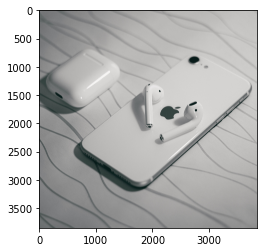

In [103]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [104]:
scaled_image = mold_image(image,cfg)

In [105]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [106]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [107]:
#extract results
r = yhat[0]

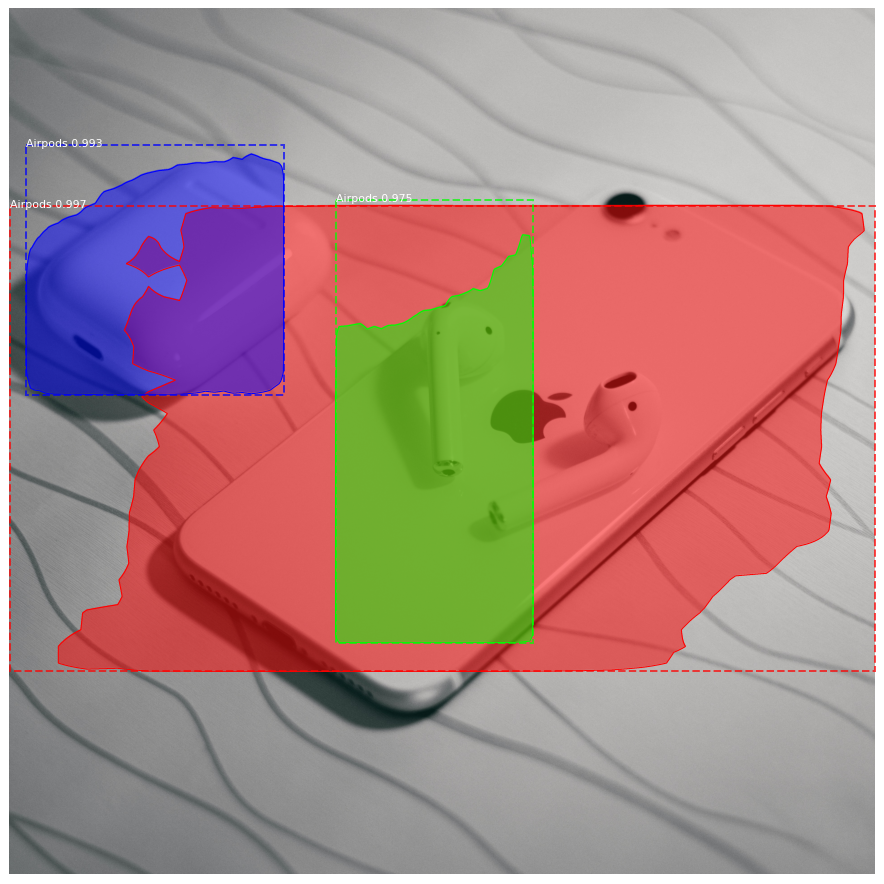

In [108]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

In [109]:
image_path = 'cv_images_test/cv_images_train/5e34c013f276e673b44ace56-0.jpeg'

In [197]:
image =skimage.io.imread(image_path)

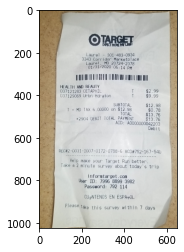

In [198]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [199]:
scaled_image = mold_image(image,cfg)

In [200]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [201]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [202]:
#extract results
r = yhat[0]

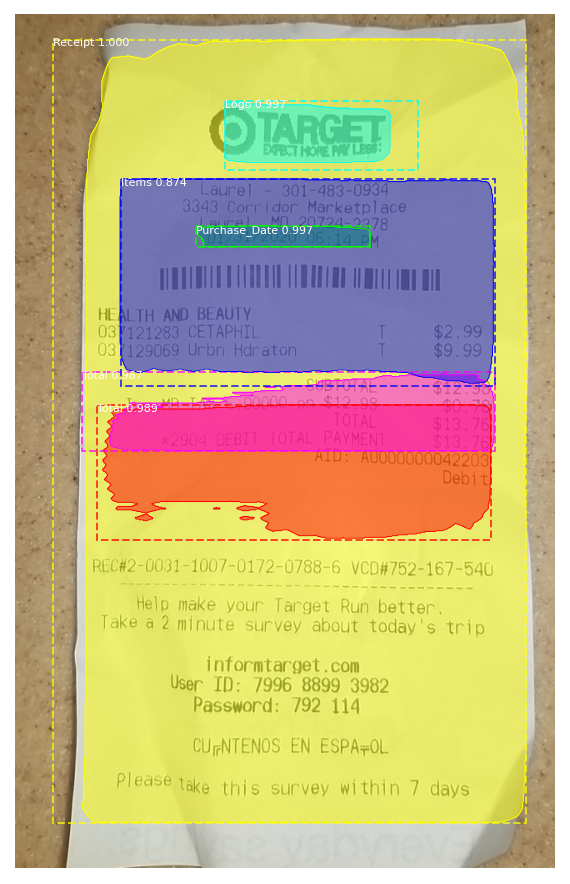

In [203]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

In [313]:
image_path = 'target_receipt_images/target_images_test/5e34c027e01a8e745ebe6da9-0.jpeg'

In [314]:
image =skimage.io.imread(image_path)

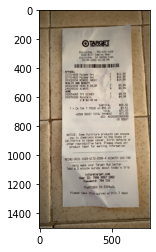

In [315]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [316]:
scaled_image = mold_image(image,cfg)

In [317]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [318]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [319]:
#extract results
r = yhat[0]

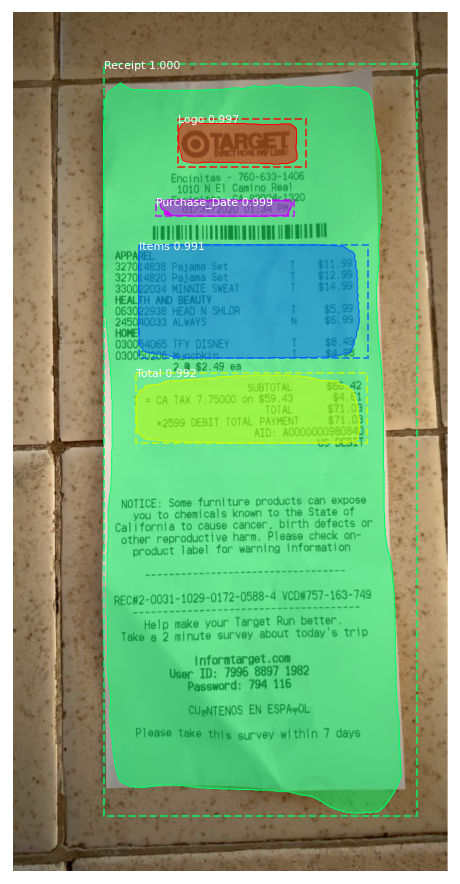

In [320]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

In [212]:
image_path = 'target_receipt_images/target_images_test/5e34c01ef0a5d0772cadc904-0.jpeg'

In [213]:
image =skimage.io.imread(image_path)

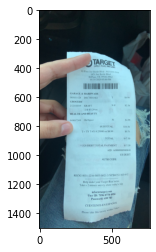

In [214]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [215]:
scaled_image = mold_image(image,cfg)

In [216]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [217]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [218]:
#extract results
r = yhat[0]

# Visualize results

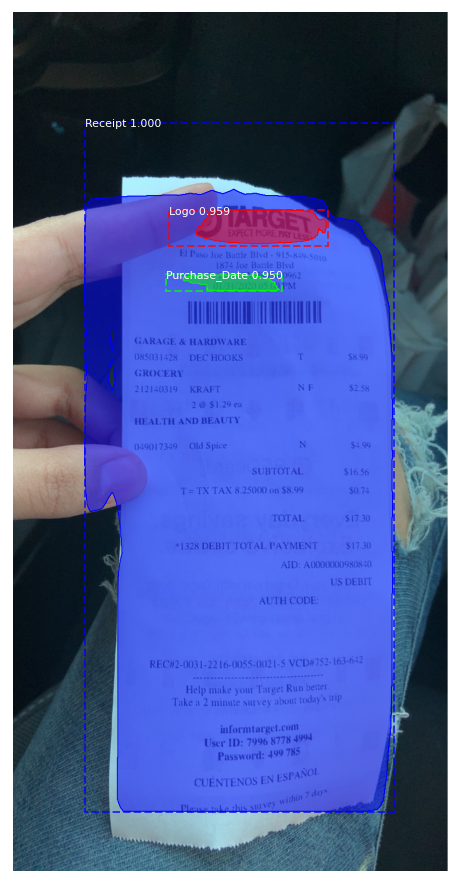

In [219]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

In [220]:
image_path = 'target_receipt_images/target_images_test/5e34c02ae01a8e745ebe6dec-0.jpeg'

In [221]:
image =skimage.io.imread(image_path)

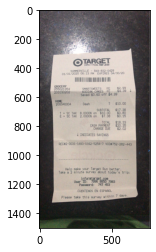

In [222]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [223]:
scaled_image = mold_image(image,cfg)

In [224]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [225]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [226]:
#extract results
r = yhat[0]

# Visualize results

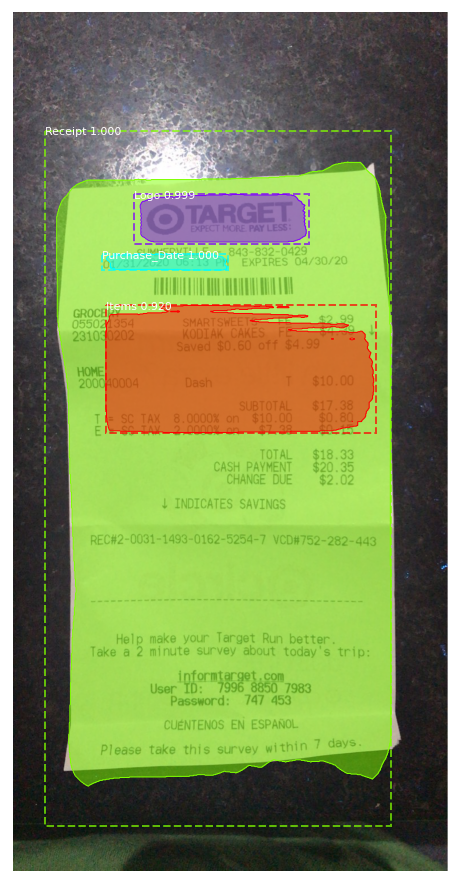

In [227]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

# load example instance not in training dataset

In [271]:
image_path = 'screen.png'

In [272]:
image =skimage.io.imread(image_path)

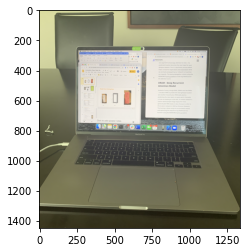

In [273]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [276]:
scaled_image = mold_image(image,cfg)

In [275]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [238]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [239]:
#extract results
r = yhat[0]

# Visualize results

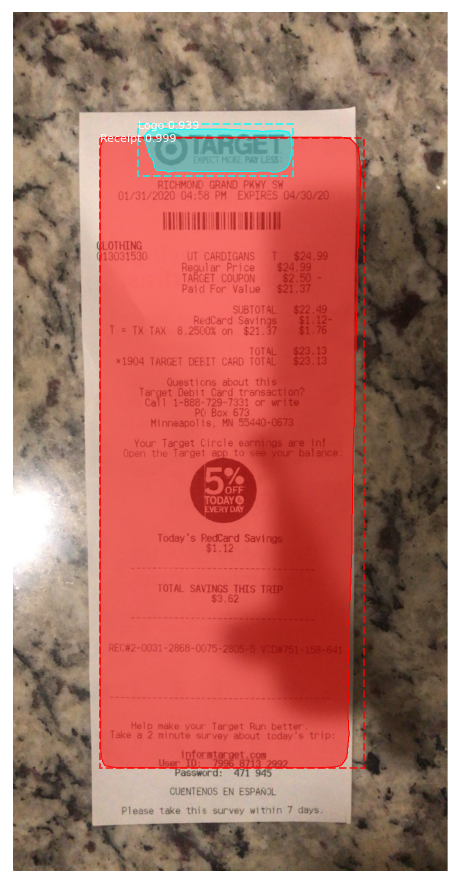

In [240]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

# load example instance not in training dataset

In [241]:
image_path = 'target_receipt_images/target_images_test/5e34c027e01a8e745ebe6da9-0.jpeg'

In [242]:
image =skimage.io.imread(image_path)

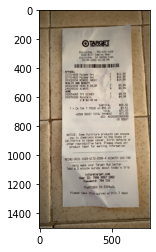

In [243]:
plt.imshow(image)

# Perform preprocessing to format in way model expects

In [244]:
scaled_image = mold_image(image,cfg)

In [245]:
#more preprocessing
sample = expand_dims(scaled_image,0)

# Make prediction

In [246]:
#make prediction
yhat = model.detect(sample, verbose = 0)

In [247]:
#extract results
r = yhat[0]

# Visualize results

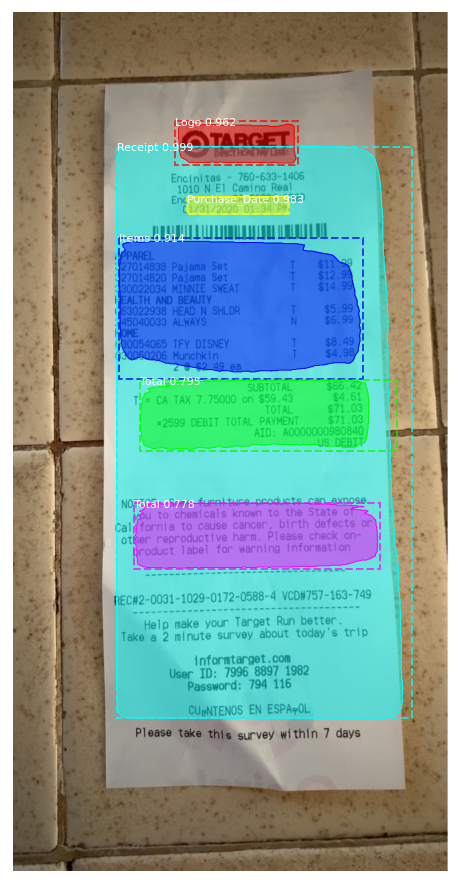

In [248]:
visualize.display_instances(image, r['rois'], r['masks'],r['class_ids'],train_set.class_names, r['scores'])

In [188]:
image_path = 'target_receipt_images/target_images/5e34ceaff276e673b44bf9ae-0.jpeg'